# Masking S-PLUS

This notebook contains the new versions of the S-PLUS mask: 
1) **finding**;
2) **segmenting**.

Before proceeding to the other notebooks, run it for all the bands: R, G and B. Hre the code build the mask for each band separetelly and, the next one build the complete mask.

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import scipy.ndimage
from astropy.visualization import hist
from scipy.ndimage import binary_closing
from sklearn.cluster import KMeans
from astropy.nddata import Cutout2D

### User inputs

The user needs to define the field and the band name before proceed

In [2]:
field = 'STRIPE82-0113'#'HYDRA-0167'
band_name = 'I' #'R' #'G' #
if band_name == 'R':
    band = 0
if band_name == 'G':
    band = 1
if band_name == 'I':
    band = 2

## 0) Loading data

In [3]:
#Cropped RGB image
data = np.load('results/'+field+'/crop_RGB_'+field+'.npz')
#Original mask
original_mask = np.load('results/'+field+'/original_mask-RGB_'+field+'.npz')

In [4]:
data = data['img']
original_mask = original_mask['mask']

In [5]:
#Getting the percentage of area from the original image
p_original_mask = np.sum(original_mask)/(original_mask.shape[0]*original_mask.shape[1])
print(f'Percentage of area covered by the original mask is {100*p_original_mask:.2f} %')

Percentage of area covered by the original mask is 26.86 %


In [6]:
#Getting the positions of the bright objects
sat = pd.read_csv('results/'+field+'/cut_saturated-'+field+'.csv')
sat_x = sat['x'] 
sat_y = sat['y']

## 1) Mask version I: finding the objects

Notice that here I consider only the respective band in question

In [7]:
#Getting just the chosen band
img = data[:, :, band]*original_mask
oimg = data[:, :, band]*(1. - original_mask) #Just to plot after

Here I am finding the bright stars just function `label`:

In [8]:
flabels, fnumobjects = scipy.ndimage.label(img)

In [9]:
print('The number of objects found is:', fnumobjects)

The number of objects found is: 1659698


Here I am selecting the objects according to their labels:

In [10]:
fslices = scipy.ndimage.find_objects(flabels)

In [11]:
del sat

Here I select the size of the objects of interest. Since the bright stars are larger objects, it is a larger number (in pixel scale). This is the limit to consider the small objects as well, meaning the maximum size to them too.

In [12]:
flim = 50
# if field == 'STRIPE82-0113':
#     flim = 180
# if field == 'HYDRA-0167':
#     flim = 130

Here I split the objects in small and larger ones

In [13]:
fshapes_objs = {}
fsmallest_slices = {}
flargest_slices = {}
for i, sli in enumerate(fslices):
    fshapes_objs[i] = flabels[sli].shape
    if fshapes_objs[i][0] > flim or fshapes_objs[i][1] > flim:
        flargest_slices[i] = sli
        continue
    fsmallest_slices[i] = sli

To have an idea of the area of the selected objects, I saved it

In [14]:
area = np.zeros(len(fshapes_objs))
for i in range(len(fshapes_objs)):
    area[i] = fshapes_objs[i][0]*fshapes_objs[i][1]

In [15]:
np.savetxt('results/'+field+'/'+band_name+'-area-finding.txt', area)

And here we can see the distribution of the objects with different sizes, using the `blocks` (Bayesian blocks) for dynamic bin widths

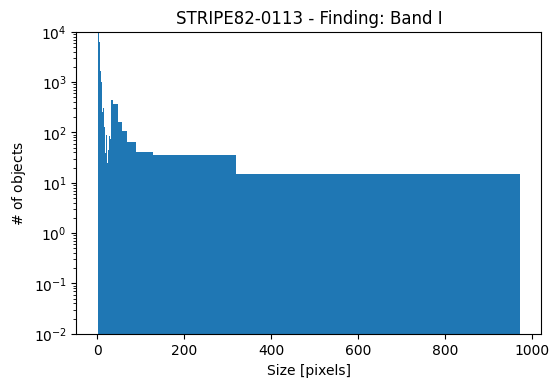

In [16]:
plt.figure(dpi = 100)
hist(np.sqrt(area), bins = 'blocks')
plt.yscale('log')
plt.title(field+' - Finding: Band '+band_name)
plt.ylabel('$\#$ of objects')
plt.xlabel('Size [pixels]')
plt.ylim(10**(-2), 10**4)
plt.savefig('results/'+field+'/finding-distro_objects-band_'+band_name+'.png', bbox_inches='tight')

The core of the mask is this part of the code, where I:
- throw away the small objects;
- keep only the bright stars (according to already existing mask for S-PLUS);
- complete the mask using `binary_closing` in order to remove the linear bleed trails;

In [17]:
fmask = np.copy(flabels)
for sli in fsmallest_slices.values():
    fmask[sli] = 0
fmask[np.where(fmask > 0)] = 1
aux_mask = np.copy(fmask)
for sli in flargest_slices.values():
    for j in range(sat_x.shape[0]):
        if sat_x[j] > sli[1].start and sat_x[j] < sli[1].stop and sat_y[j] > sli[0].start and sat_y[j] < sli[0].stop:
            aux_mask[sli] = 0
fmask = fmask - aux_mask
fmask = binary_closing(fmask, iterations = 4)#2)
fmask = 1. - fmask

In [18]:
#Saving the mask
np.savez('results/'+field+'/'+field+'-finding_mask_'+band_name+'.npz', mask = fmask)

The comparison of the covered area by the original and new mask is given by:

In [19]:
#Percentage of the sky
p_fmask = ((fmask.shape[0]*fmask.shape[1]) - np.sum(fmask))/(fmask.shape[0]*fmask.shape[1])
print(f'Percentage of area covered by the original mask is {100*p_original_mask:.2f} % and percentage of the new mask is {100*p_fmask:.2f} %')

Percentage of area covered by the original mask is 26.86 % and percentage of the new mask is 3.33 %


In [20]:
del flabels, fnumobjects, fslices, fshapes_objs, fsmallest_slices, flargest_slices, area, aux_mask

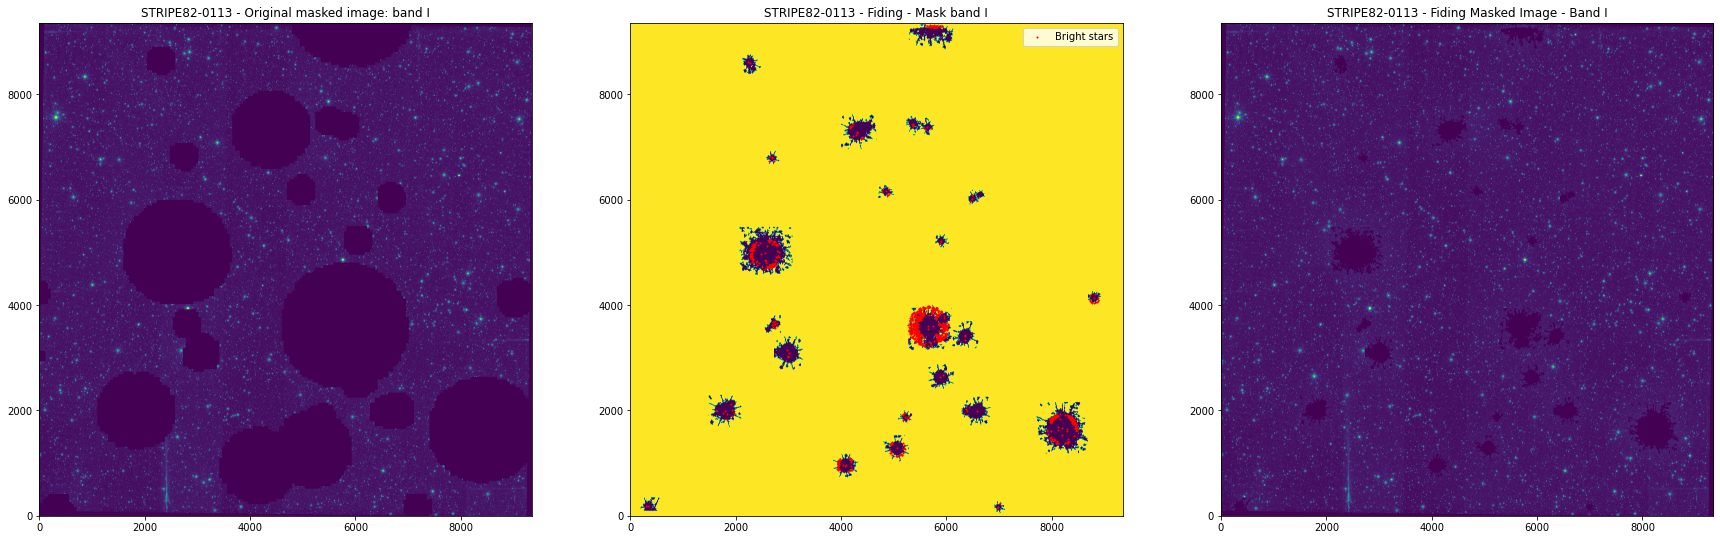

In [21]:
figure_size = 30
plt.figure(figsize=(figure_size,10))
plt.subplot(1,3,1)
plt.imshow(oimg, origin='lower')
plt.title(field+' - Original masked image: band '+band_name)
plt.subplot(1,3,2)
plt.imshow(fmask, origin='lower')
plt.scatter(sat_x, sat_y, color = 'red', s = 1, label = 'Bright stars')
plt.legend()
plt.title(field+' - Fiding - Mask band '+band_name)
plt.subplot(1,3,3)
plt.imshow(fmask*data[:,:,band], origin='lower')
plt.title(field+' - Fiding Masked Image - Band '+band_name)
plt.savefig('results/'+field+'/'+field+'-finding-comparison_'+band_name+'.png', bbox_inches='tight')

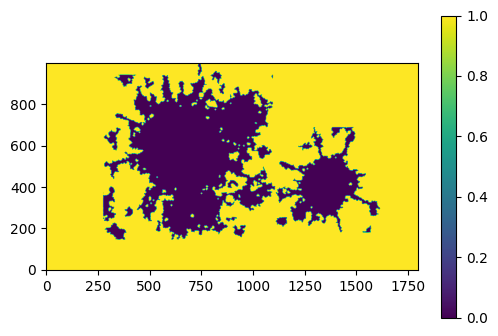

In [22]:
plt.figure(dpi = 100)
plt.imshow(fmask[3000:4000, 5000:6800], origin='lower')
plt.colorbar()

In [23]:
del fmask

## 2) Mask version II: Image segmentation + Finding the objects

Because I am applying the **image segmentation** using `kmeans` build for images (see the library [`kmeans`](https://docs.opencv.org/4.5.2/d1/d5c/tutorial_py_kmeans_opencv.html) -- notice that it is extremely fast and I can deal with the whole big field image), first I need to find the best $k$ value. 

I will do this using the **Elbow method**. This method consists of choosing the best $k$ value based in the point value of it where the _inertia_ starts to not change significantly. The _inertia_ the sum of squared distance of samples to their closest cluster center. Because it is built as a method for the original [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) I will use it. It is really expensive to do for the whole image, then, I have done this for just one small part of the image.

In [24]:
#Taking and masking only the specified band
img = data[:,:,band]*original_mask

In [25]:
#Selecting the part of the image
if field == 'STRIPE82-0113':
    part = data[2300:4200, 5000:6900, band]
if field == 'HYDRA-0167':
    part = data[2400:3100, 6800:7600, band]

In [26]:
vec = part.reshape((-1, 1))
vec = np.float32(vec)

In [27]:
EM = []
for i in range(1, 9):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(vec)
    inertia = kmeans.inertia_
    EM.append(inertia)

The `inertia` is also know as _total within-cluster sum of square_ (WCSS):

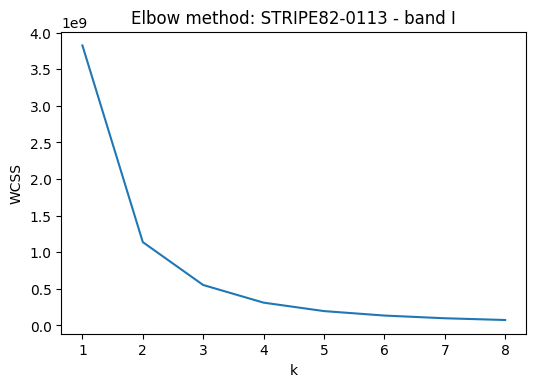

In [28]:
plt.figure(dpi = 100)
plt.title('Elbow method: '+field+' - band '+ band_name)
plt.plot(list(np.arange(1, 9)), EM)
plt.ylabel('WCSS')
plt.xlabel('k')
plt.savefig('results/'+field+'/'+field+'-elbow_method-'+band_name+'.png', bbox_inches='tight')

#### K-Means Color Clustering

The idea of applying `kmeans` here is to treat the $M \times N$ pixels as data points, to cluster using the clustering method. In this way, pixels that belong to a given cluster will be more similar in color than pixels belonging to a separate cluster. Here I am using the specific library to deal with images.

In [29]:
#Reshaping the image - flatenizing it
vectorized = img.reshape((-1, 1))

In [30]:
#Ensuring that each pixel is a float32
vectorized = np.float32(vectorized)

In [31]:
#Defining the criteria to do the clusterization (this is the best for this work)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [32]:
#Choosing the number of clusters according to Elbow method
K = 5

In [33]:
attempts = 10
ret, label, center = cv2.kmeans(vectorized, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

In [34]:
center = np.uint8(center)

In [35]:
res = center[label.flatten()]
result_image = res.reshape((img.shape))

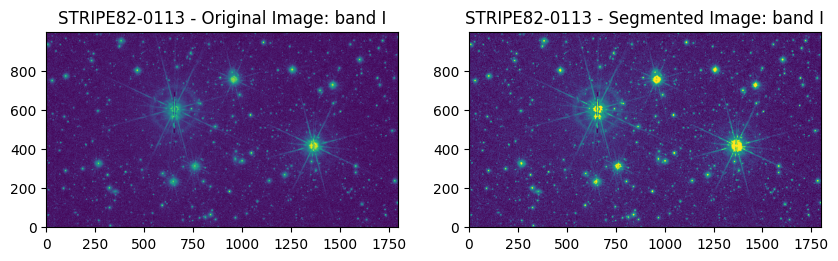

In [36]:
#Checking the effects of the segmentation
if field == 'STRIPE82-0113':
    org = img[3000:4000, 5000:6800]
    res = result_image[3000:4000, 5000:6800]
if field == 'HYDRA-0167':
    org = img[5300:5800, 7900:8600]
    res = result_image[5300:5800, 7900:8600]
plt.figure(dpi = 100, figsize = (10, 20))
plt.subplot(1,2,1)
plt.title(field+' - Original Image: band '+band_name)
plt.imshow(org, origin='lower')
plt.subplot(1,2,2)
plt.title(field+' - Segmented Image: band '+band_name)
plt.imshow(res, origin='lower')
plt.savefig('results/'+field+'/'+field+'-result_segmentation-'+band_name+'.png', bbox_inches='tight')

Now, I am finding the bright stars using the method `label`:

In [37]:
slabels, snumobjects = scipy.ndimage.label(result_image)

In [38]:
print('The number of objects found is:', snumobjects)

The number of objects found is: 1973353


Again, selecting the objects according to their labels:

In [39]:
sslices = scipy.ndimage.find_objects(slabels)

Selecting the limit between small and larger objects:

In [40]:
slim = 40 #110

In [41]:
sshapes_objs = {}
ssmallest_slices = {}
slargest_slices = {}
for i, sli in enumerate(sslices):
    sshapes_objs[i] = slabels[sli].shape
    if sshapes_objs[i][0] > slim or sshapes_objs[i][1] > slim:
        slargest_slices[i] = sli
        continue
    ssmallest_slices[i] = sli

Saving the area of the objects:

In [42]:
area = np.zeros(len(sshapes_objs))
for i in range(len(sshapes_objs)):
    area[i] = sshapes_objs[i][0]*sshapes_objs[i][1]

In [43]:
np.savetxt('results/'+field+'/'+band_name+'-area-segmenting.txt', area)

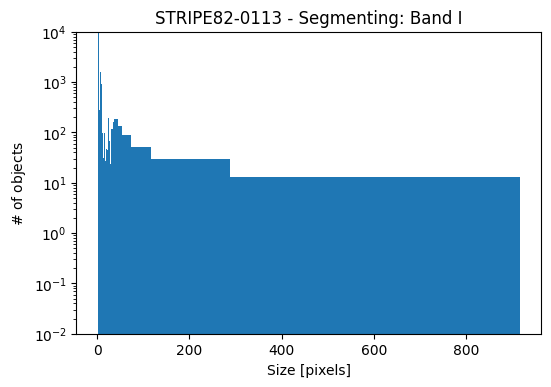

In [44]:
plt.figure(dpi = 100)
hist(np.sqrt(area), bins = 'blocks')
plt.yscale('log')
plt.title(field+' - Segmenting: Band '+band_name)
plt.ylabel('$\#$ of objects')
plt.xlabel('Size [pixels]')
plt.ylim(10**(-2), 10**4)
plt.savefig('results/'+field+'/segmenting-distro_objects-band_'+band_name+'.png', bbox_inches='tight')

Again, applying the core of the mask:

In [45]:
smask = np.copy(slabels)
for sli in ssmallest_slices.values():
    smask[sli] = 0
smask[np.where(smask > 0)] = 1
aux_mask = np.copy(smask)
for sli in slargest_slices.values():
    for j in range(sat_x.shape[0]):
        if sat_x[j] > sli[1].start and sat_x[j] < sli[1].stop and sat_y[j] > sli[0].start and sat_y[j] < sli[0].stop:
            aux_mask[sli] = 0
smask = smask - aux_mask
smask = binary_closing(smask, iterations = 4)#2)
smask = 1. - smask

In [46]:
#Saving the mask
np.savez('results/'+field+'/'+field+'-segmenting_mask_'+band_name+'.npz', mask = smask)

In [47]:
#Percentage of the sky
p_smask = ((smask.shape[0]*smask.shape[1]) - np.sum(smask))/(smask.shape[0]*smask.shape[1])
print(f'Percentage of area covered by the original mask is {100*p_original_mask:.2f} % and percentage of the new mask is {100*p_smask:.2f} %')

Percentage of area covered by the original mask is 26.86 % and percentage of the new mask is 2.08 %


In [48]:
del slabels, snumobjects, sslices, sshapes_objs, ssmallest_slices, slargest_slices, area, aux_mask, img, vectorized, criteria
del ret, label, center, res, result_image

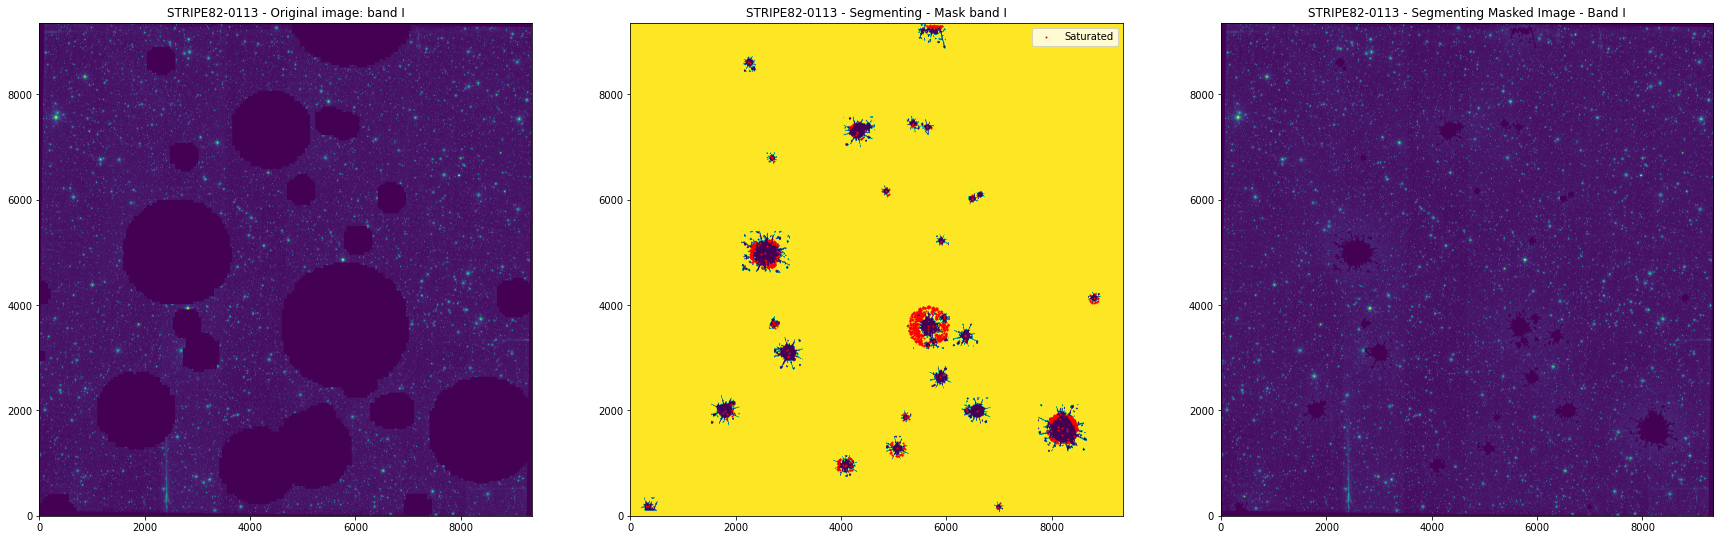

In [49]:
figure_size = 30
plt.figure(figsize=(figure_size,10))
plt.subplot(1,3,1)
plt.imshow(oimg, origin='lower')
plt.title(field+' - Original image: band '+band_name)
plt.subplot(1,3,2)
plt.imshow(smask, origin='lower')
plt.scatter(sat_x, sat_y, color = 'red', s = 1, label = 'Saturated')
plt.legend()
plt.title(field+' - Segmenting - Mask band '+band_name)
plt.subplot(1,3,3)
plt.imshow(smask*data[:,:,band], origin='lower')
plt.title(field+' - Segmenting Masked Image - Band '+band_name)
plt.savefig('results/'+field+'/'+field+'-segmenting-comparison_'+band_name+'.png', bbox_inches='tight')

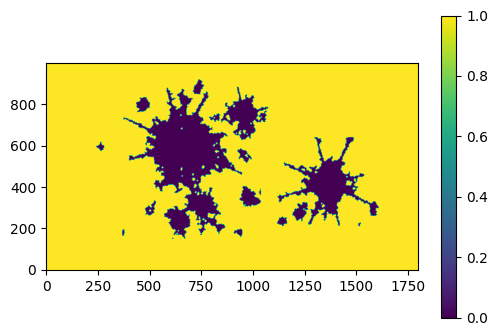

In [50]:
plt.figure(dpi = 100)
plt.imshow(smask[3000:4000, 5000:6800], origin='lower')
plt.colorbar()

In [51]:
del smask